In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import os
from IPython.display import IFrame
from tensorflow.keras.models import load_model, Model

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

# routines for Cifar10 dataset

In [2]:
# Plot confusion matrix
plt.rcParams['figure.figsize'] = [10,7]

def plot_confusion_matrix_cifar10(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          saveas='confmat',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    figure = plt.figure(1, figsize= (8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.clim(0, 800)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    labels = ['plane', 'car', 'bird','cat','deer','dog','frog','horse','ship','truck']
    plt.yticks(np.arange(len(labels)), labels)
    plt.xticks(np.arange(len(labels)), labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    figure.savefig(saveas+".pdf", bbox_inches='tight')
    plt.show()

In [3]:
def load_cifar10(scaled=False):
    N_CLASSES=10
    # get the data
    (x_train,y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    if scaled:
        x_train, x_test = x_train/255.0, x_test/255.0
    # do a 1hot encoding on labels
    y_test1H = tf.keras.utils.to_categorical(y_test, N_CLASSES)
    return x_test, y_test, y_test1H

In [4]:
import pandas as pd
# this routine is extracting relevant information from the confusion matrix
def analyze_predictions_Cifar10(cm):
    TP_order = np.argsort(cm.diagonal())
    labels = np.array(['plane', 'car', 'bird','cat','deer','dog','frog','horse','ship','truck'])

    print("\n least correct predictions")
    df_wrong = pd.DataFrame(zip(labels[TP_order[:10]], cm.diagonal()[TP_order[:10]]),
                   columns =['label', 'times correct predicted'])
    display(df_wrong)

    print("\n most correct predictions, labels, times correct predicted:")
    df_correct = pd.DataFrame(zip(labels[TP_order[-10:]], cm.diagonal()[TP_order[-10:]]),
                   columns =['label', 'times correct predicted'])
    display(df_correct)

    print("\n most confused labels:")
    cm_nodiag = cm-np.diag(cm.diagonal())
    ind = np.unravel_index(np.argsort(cm_nodiag, axis=None), cm_nodiag.shape)
    conf_labels = []
    for n in range(1,11):
        conf_labels.append([cm_nodiag[ind[0][-n],ind[1][-n]], labels[ind[0][-n]], labels[ind[1][-n]] ])
    df_conf = pd.DataFrame(conf_labels,
                   columns =['times confused', 'actual label', 'predicted label'])
    display(df_conf)

    print("\n most true negatives")
    FN = cm_nodiag.sum(axis=0)
    FN_order = np.argsort( FN )
    df_fn = pd.DataFrame(zip(labels[FN_order[:10]], FN[FN_order[:10]]),
                   columns =['label', 'times wrong predicted'])
    display(df_fn)
    
    print("\n biggest std for column (for which classes the cnn was not very percice):")
    ind_std = np.argsort(  (cm_nodiag + np.diag(cm_nodiag.mean(axis=0))).std(axis=0) )
    df_unsure = pd.DataFrame(labels[ind_std[-10:]],
                   columns =['times label']).T
    
    
    display(df_unsure)

# Cifar10

## squeeze net not augmented 

In [5]:
# Cifar10 has 10 classes
N_CLASSES = 10
# our input dimensions
INSHAPE = 32, 32, 3

In [6]:
x_test, y_test, y_test1H = load_cifar10(scaled=False)

In [7]:
tf.keras.backend.clear_session()
# Load the model from disk
model = load_model(os.path.join('models','squeezeNet_cifar10_noaug.h5'))

# Evaluate the model
test_res = model.evaluate(x_test , y_test1H)

# Print the results as a dictionary {<metric name>: <value>}
test_res_dict = dict(zip(model.metrics_names, test_res))
print(test_res_dict)

313/313 [==============================] - 8s 24ms/step - loss: 1.2048 - accuracy: 0.6521
{'loss': 1.2047618627548218, 'accuracy': 0.6521000266075134}


In [8]:
# plot confusion matrix
p_test = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)

Confusion matrix, without normalization
[[703  21  65  21  18  12  16  19  78  47]
 [ 28 760   5  14   6   7   9   4  32 135]
 [ 78   8 529  91  89  65  76  32  19  13]
 [ 19   8  78 465  70 174  88  43  19  36]
 [ 28   4 110  64 580  35  75  86  13   5]
 [ 24   7  53 220  52 538  30  58   8  10]
 [ 13   3  54  79  72  29 715   9  11  15]
 [ 19   1  48  51  87  60   1 714   3  16]
 [ 72  33  18  21  11   9  10   6 800  20]
 [ 29 120  12  27   7  10  20  20  38 717]]


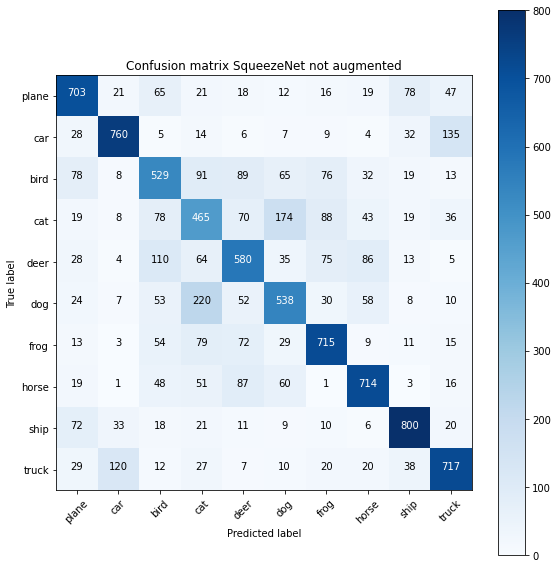

In [9]:
plot_confusion_matrix_cifar10(cm, list(range(10)),
                          title='Confusion matrix SqueezeNet not augmented',
                          saveas='squeezeNet_cifar10_noaug_confmat',
                          cmap=plt.cm.Blues)

In [10]:
analyze_predictions_Cifar10(cm)


 least correct predictions


,label,times correct predicted
0,cat,465
1,bird,529
2,dog,538
3,deer,580
4,plane,703
5,horse,714
6,frog,715
7,truck,717
8,car,760
9,ship,800



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,cat,465
1,bird,529
2,dog,538
3,deer,580
4,plane,703
5,horse,714
6,frog,715
7,truck,717
8,car,760
9,ship,800



 most confused labels:


,times confused,actual label,predicted label
0,220,dog,cat
1,174,cat,dog
2,135,car,truck
3,120,truck,car
4,110,deer,bird
5,91,bird,cat
6,89,bird,deer
7,88,cat,frog
8,87,horse,deer
9,86,deer,horse



 most true negatives


,label,times wrong predicted
0,car,205
1,ship,221
2,horse,277
3,truck,297
4,plane,310
5,frog,325
6,dog,401
7,deer,412
8,bird,443
9,cat,588



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,ship,plane,horse,bird,frog,deer,car,truck,dog,cat


In [11]:
IFrame("./models/squeezeNet_cifar10_noaug.pdf", width=900, height=400)

## squeeze net augmented 

In [12]:
# Cifar10 has 10 classes
N_CLASSES = 10
# our input dimensions
INSHAPE = 32, 32, 3

In [13]:
x_test, y_test, y_test1H = load_cifar10(scaled=True)

In [14]:
tf.keras.backend.clear_session()
# Load the model from disk
model = load_model(os.path.join('models','squeezeNet_cifar10_aug.h5'))

# Evaluate the model
test_res = model.evaluate(x_test , y_test1H)

# Print the results as a dictionary {<metric name>: <value>}
test_res_dict = dict(zip(model.metrics_names, test_res))
print(test_res_dict)

313/313 [==============================] - 9s 28ms/step - loss: 0.9249 - accuracy: 0.6733
{'loss': 0.924884557723999, 'accuracy': 0.67330002784729}


In [15]:
# plot confusion matrix
p_test = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)

Confusion matrix, without normalization
[[732  42  32  11  16   6  11  26  57  67]
 [ 13 847   1   2   0   3   6   3   9 116]
 [ 83  10 496  68 107  52  87  57  14  26]
 [ 21  25  52 383  56 220 114  57  22  50]
 [ 30   7  46  38 566  30 115 148   9  11]
 [  8  12  27 168  47 561  47  91   7  32]
 [ 10   9  16  50  37  19 803  18   9  29]
 [ 23   4   7  30  41  55  14 783   2  41]
 [ 84  49  11  10   4   4   9   4 774  51]
 [ 30 127   4   6   0   4  10  17  14 788]]


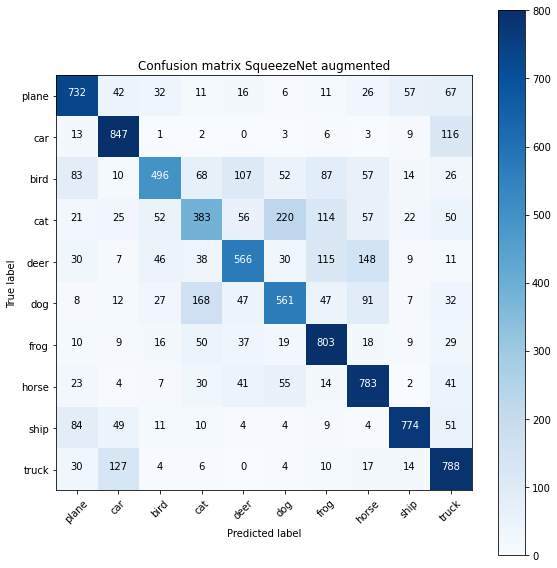

In [16]:
plot_confusion_matrix_cifar10(cm, list(range(10)),
                          title='Confusion matrix SqueezeNet augmented',
                          saveas='squeezeNet_cifar10_aug_confmat',
                          cmap=plt.cm.Blues)

In [17]:
analyze_predictions_Cifar10(cm)


 least correct predictions


,label,times correct predicted
0,cat,383
1,bird,496
2,dog,561
3,deer,566
4,plane,732
5,ship,774
6,horse,783
7,truck,788
8,frog,803
9,car,847



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,cat,383
1,bird,496
2,dog,561
3,deer,566
4,plane,732
5,ship,774
6,horse,783
7,truck,788
8,frog,803
9,car,847



 most confused labels:


,times confused,actual label,predicted label
0,220,cat,dog
1,168,dog,cat
2,148,deer,horse
3,127,truck,car
4,116,car,truck
5,115,deer,frog
6,114,cat,frog
7,107,bird,deer
8,91,dog,horse
9,87,bird,frog



 most true negatives


,label,times wrong predicted
0,ship,143
1,bird,196
2,car,285
3,plane,302
4,deer,308
5,cat,383
6,dog,393
7,frog,413
8,horse,421
9,truck,423



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,ship,bird,plane,truck,deer,car,frog,horse,cat,dog


In [18]:
IFrame("./models/squeezeNet_cifar10_aug.pdf", width=900, height=400)

# Res50Net not augmented

In [19]:
# to load the wrapped Res50Net architecture we need to recreate it here
def res50Net_transfer(input_shape, n_classes, frozen_layers=168, final_layers=[]):
    # load resnet with given input shape
    input_t = tf.keras.Input(shape=input_shape)
    res_model = tf.keras.applications.ResNet50(include_top=False,
                                              weights="imagenet",
                                              input_tensor=input_t)
    # freeze top layers of resnet
    for layer in res_model.layers[:frozen_layers]:
        layer.trainable =False

    # wrap resnet by sequencial network
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Lambda(lambda image: tf.image.resize(image, input_shape[:2])))
    model.add(res_model)
    model.add(tf.keras.layers.Flatten())

    for n_layer in final_layers: # add dense layers if we need more accuracy
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(n_layer, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

    loss = tf.keras.losses.CategoricalCrossentropy()
    adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model

In [20]:
# Cifar10 has 10 classes
N_CLASSES = 10
# our input dimensions
INSHAPE = 32, 32, 3

In [21]:
x_test, y_test, y_test1H = load_cifar10(scaled=False)

In [22]:
tf.keras.backend.clear_session()
model = res50Net_transfer(INSHAPE, N_CLASSES, frozen_layers=168, 
                          final_layers=[256, 128, 64])
model.build(x_test.shape)
model.load_weights(os.path.join('models','res50Net_cifar10_noaug.h5'))

# Evaluate the model
test_res = model.evaluate(x_test , y_test1H)

# Print the results as a dictionary {<metric name>: <value>}
test_res_dict = dict(zip(model.metrics_names, test_res))
print(test_res_dict)

313/313 [==============================] - 37s 110ms/step - loss: 1.2159 - accuracy: 0.6216
{'loss': 1.2159069776535034, 'accuracy': 0.6215999722480774}


In [23]:
# plot confusion matrix
p_test = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)

Confusion matrix, without normalization
[[667  20  59  17  32  13   7  19 119  47]
 [ 41 655   8  40  14   7  19  18  59 139]
 [ 77   5 522  80 107  56  94  41  11   7]
 [ 11  30  73 504  63 123  93  54  17  32]
 [ 15  11  80  69 602  22  86  87  17  11]
 [  5  17  58 229  55 500  46  70   7  13]
 [  3  14  70  73  85  29 709  10   4   3]
 [ 19   9  41  65  89  52  11 662  11  41]
 [104  50  11  17  25   4   4  11 704  70]
 [ 35 123   4  26  19   9   8  36  49 691]]


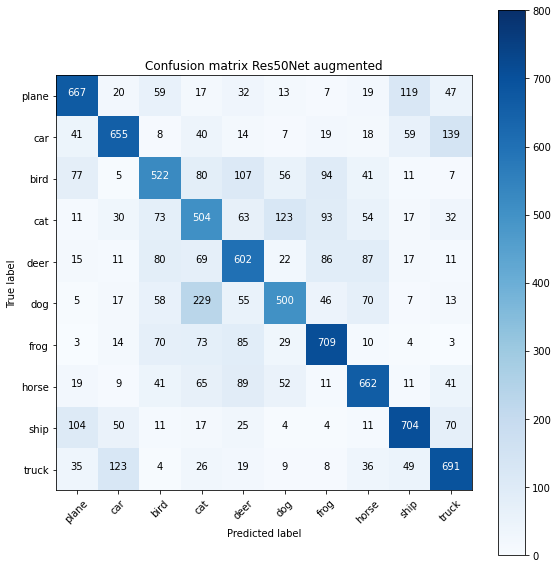

In [24]:
plot_confusion_matrix_cifar10(cm, list(range(10)),
                          title='Confusion matrix Res50Net augmented',
                          saveas='res50Net_cifar10_noaug_confmat',
                          cmap=plt.cm.Blues)

In [25]:
IFrame("./models/res50Net_cifar10_noaug.pdf", width=900, height=400)

## Res50Net augmented

In [26]:
# Cifar10 has 10 classes
N_CLASSES = 10
# our input dimensions
INSHAPE = 32, 32, 3

In [27]:
x_test, y_test, y_test1H = load_cifar10(scaled=False)

In [28]:
tf.keras.backend.clear_session()
model = res50Net_transfer(INSHAPE, N_CLASSES, frozen_layers=168, 
                          final_layers=[256, 128, 64])
model.build(x_test.shape)
model.load_weights(os.path.join('models','res50Net_cifar10_aug.h5'))

# Evaluate the model
test_res = model.evaluate(x_test , y_test1H)

# Print the results as a dictionary {<metric name>: <value>}
test_res_dict = dict(zip(model.metrics_names, test_res))
print(test_res_dict)

313/313 [==============================] - 37s 109ms/step - loss: 1.0383 - accuracy: 0.6469
{'loss': 1.038275122642517, 'accuracy': 0.6468999981880188}


In [29]:
# plot confusion matrix
p_test = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)

Confusion matrix, without normalization
[[709  26  30  18  19   8   9  24 111  46]
 [ 26 733   2  17   2  11  19  12  47 131]
 [ 74  19 499  57  84  47 144  53  18   5]
 [ 14  51  59 460  36 114 166  62  12  26]
 [ 25  10  48  42 542  14 176 105  19  19]
 [ 12  24  35 178  39 522  87  73   6  24]
 [  6  18  36  32  37  26 827   7   4   7]
 [ 29  19  11  46  69  35  27 715   7  42]
 [ 83  62   4   6  10   1   4   9 763  58]
 [ 32 143   2  19   8  10  10  30  47 699]]


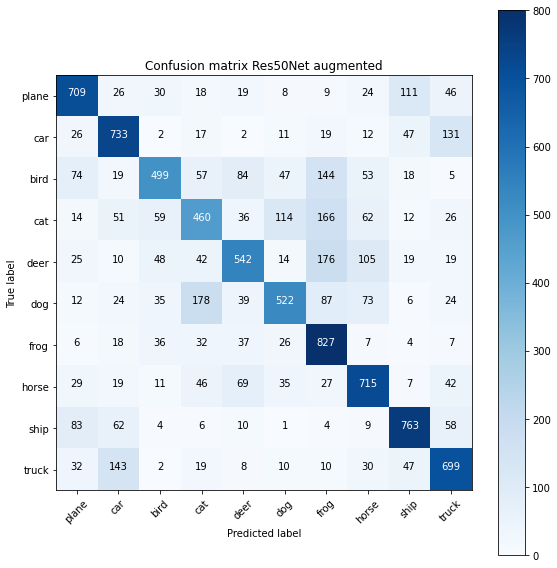

In [30]:
plot_confusion_matrix_cifar10(cm, list(range(10)),
                          title='Confusion matrix Res50Net augmented',
                          saveas='res50Net_cifar10_aug_confmat',
                          cmap=plt.cm.Blues)

In [31]:
analyze_predictions_Cifar10(cm)


 least correct predictions


,label,times correct predicted
0,cat,460
1,bird,499
2,dog,522
3,deer,542
4,truck,699
5,plane,709
6,horse,715
7,car,733
8,ship,763
9,frog,827



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,cat,460
1,bird,499
2,dog,522
3,deer,542
4,truck,699
5,plane,709
6,horse,715
7,car,733
8,ship,763
9,frog,827



 most confused labels:


,times confused,actual label,predicted label
0,178,dog,cat
1,176,deer,frog
2,166,cat,frog
3,144,bird,frog
4,143,truck,car
5,131,car,truck
6,114,cat,dog
7,111,plane,ship
8,105,deer,horse
9,87,dog,frog



 most true negatives


,label,times wrong predicted
0,bird,227
1,dog,266
2,ship,271
3,plane,301
4,deer,304
5,truck,358
6,car,372
7,horse,375
8,cat,415
9,frog,642



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,bird,plane,deer,horse,ship,dog,truck,car,cat,frog


In [32]:
IFrame("./models/res50Net_cifar10_aug.pdf", width=900, height=400)

# Tiny-ImageNet

In [33]:
from functools import partial
from keras.preprocessing.image import ImageDataGenerator
import os
import requests
import zipfile
def load_TIN(batchsize=10000):
    
    # Retrieve the data
    if not os.path.exists(os.path.join('data','tiny-imagenet-200.zip')):
        url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
        # Get the file from web
        r = requests.get(url)

        if not os.path.exists('data'):
            os.mkdir('data')

      # Write to a file
        with open(os.path.join('data','tiny-imagenet-200.zip'), 'wb') as f:
            f.write(r.content)
    else:
          print("The zip file already exists.")

    if not os.path.exists(os.path.join('data', 'tiny-imagenet-200')):
        with zipfile.ZipFile(os.path.join('data','tiny-imagenet-200.zip'), 'r') as zip_ref:
            zip_ref.extractall('data')
    else:
        print("The extracted data already exists")
    
    def get_test_labels_df(test_labels_path):
        """ Reading the test data labels for all files in the test set as a data frame """
        test_df = pd.read_csv(test_labels_path, sep='\t', index_col=None, header=None)
        test_df = test_df.iloc[:,[0,1]].rename({0:"filename", 1:"class"}, axis=1)
        return test_df

    image_gen = ImageDataGenerator(samplewise_center=False)
    test_df = get_test_labels_df('./data/tiny-imagenet-200/val/val_annotations.txt')
    test_gen = image_gen.flow_from_dataframe(
        test_df, directory=os.path.join('./data/tiny-imagenet-200/val/images'), 
        target_size=PICTURE_SHAPE, classes=None,
        class_mode='categorical', shuffle=False,batch_size=batchsize
    )
    return test_gen

In [34]:
def plot_confusion_matrix_TIN(cm,
                          title='Confusion matrix',
                          cmap=plt.cm.jet,
                          saveas="confmat"):
    figure = plt.figure(1, figsize= (8, 8))
    ticks=[0, 50, 100, 150, 199]
    plt.imshow(cm, interpolation='none',cmap=cmap)
    plt.clim(0, 50)
    plt.colorbar()
    plt.xticks(ticks,fontsize=16)
    plt.yticks(ticks,fontsize=16)
    plt.tight_layout()
    plt.title(title,fontsize=16)
    plt.ylabel('True label',fontsize=16)
    plt.xlabel('Predicted label',fontsize=16)
    figure.savefig(saveas+".pdf", bbox_inches='tight')
    plt.show()

In [35]:
import pandas as pd
def analyze_predictions_TIN(cm):
    TP_order = np.argsort(cm.diagonal())
    dt = pd.read_csv('./data/tiny-imagenet-200/words.txt', index_col=0, skiprows=1, sep='\t',).T
    labels = []
    for key in test_gen.class_indices.keys():
        labels.append(dt[key][0].split(",")[0])
    labels = np.array(labels)

    print("\n least correct predictions")
    df_wrong = pd.DataFrame(zip(labels[TP_order[:10]], cm.diagonal()[TP_order[:10]]),
                   columns =['label', 'correct amount'])
    display(df_wrong)

    print("\n most correct predictions, labels, times correct predicted:")
    df_correct = pd.DataFrame(zip(labels[TP_order[-10:]][::-1], cm.diagonal()[TP_order[-10:]][::-1]),
                   columns =['label', 'correct amount'])
    display(df_correct)

    print("\n most confused labels:")
    cm_nodiag = cm-np.diag(cm.diagonal())
    ind = np.unravel_index(np.argsort(cm_nodiag, axis=None), cm_nodiag.shape)
    conf_labels = []
    for n in range(1,11):
        conf_labels.append([ labels[ind[0][-n]], labels[ind[1][-n]], cm_nodiag[ind[0][-n],ind[1][-n]]])
    df_conf = pd.DataFrame(conf_labels,
                   columns =['actual label', 'predicted label','times confused'])
    display(df_conf)

    print("\n biggest std for column (for which classes the cnn was not very percice):")
    ind_std = np.argsort(  (cm_nodiag + np.diag(cm_nodiag.mean(axis=0))).std(axis=0) )
    df_unsure = pd.DataFrame(labels[ind_std[-10:]],
                   columns =['times label']).T
    display(df_unsure)
    
    print(pd.concat([df_wrong, df_correct, df_conf], axis=1).to_latex(index=False))

## squeeze net not augmented 

In [36]:
# TinyIageNet has 200 classes
N_CLASSES = 200
# our input dimensions
INSHAPE = 64, 64, 3
PICTURE_SHAPE = INSHAPE[0], INSHAPE[1]

In [37]:
test_gen = load_TIN()

Found 10000 validated image filenames belonging to 200 classes.


In [38]:
tf.keras.backend.clear_session()
# Load the model from disk
model = load_model(os.path.join('models','squeezeNetTIN_noaug.h5'))

In [39]:
# Evaluate the model
test_res = model.evaluate(test_gen)
# Print the results as a dictionary {<metric name>: <value>}
test_res_dict = dict(zip(model.metrics_names, test_res))
print(test_res_dict)

1/1 [==============================] - 31s 31s/step - loss: 3.2492 - accuracy: 0.3126
{'loss': 3.249164342880249, 'accuracy': 0.3125999867916107}


In [40]:
p_test = model.predict(test_gen[0][0]).argmax(axis=1)
cm = confusion_matrix(np.argmax(test_gen[0][1],axis=1), p_test)

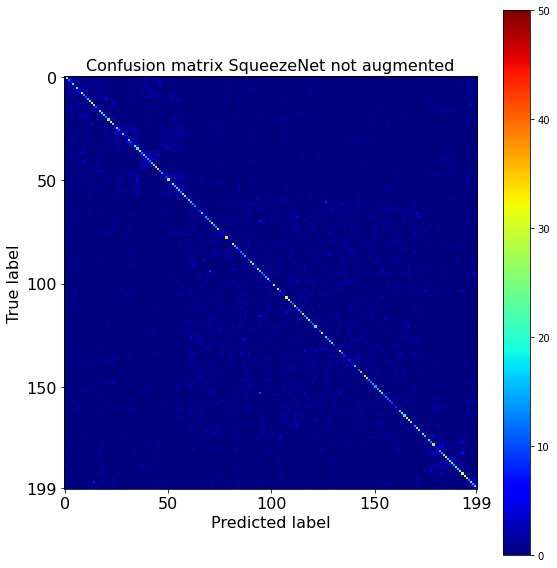

In [41]:
plot_confusion_matrix_TIN(cm,title='Confusion matrix SqueezeNet not augmented',
                          saveas='squeezeNet_TIN_noaug_confmat',)

In [42]:
IFrame("./models/squeezeNetTIN_noaug.pdf", width=900, height=400)

In [43]:
analyze_predictions_TIN(cm)


 least correct predictions


,label,correct amount
0,wooden spoon,0
1,teddy,1
2,Labrador retriever,1
3,plunger,1
4,umbrella,1
5,broom,2
6,bucket,3
7,fountain,3
8,potter's wheel,3
9,chain,3



 most correct predictions, labels, times correct predicted:


,label,correct amount
0,dugong,36
1,rugby ball,36
2,school bus,35
3,monarch,35
4,goldfish,34
5,brass,34
6,lifeboat,34
7,sulphur butterfly,34
8,obelisk,32
9,espresso,31



 most confused labels:


,actual label,predicted label,times confused
0,sports car,convertible,10
1,convertible,beach wagon,9
2,altar,organ,8
3,mashed potato,potpie,7
4,goose,black stork,7
5,fly,bee,7
6,police van,limousine,7
7,lemon,banana,7
8,coral reef,brain coral,7
9,beach wagon,convertible,7



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,black stork,limousine,tarantula,kimono,seashore,organ,beach wagon,potpie,brown bear,convertible


\begin{tabular}{lrlrllr}
\toprule
             label &  correct amount &             label &  correct amount &  actual label & predicted label &  times confused \\
\midrule
      wooden spoon &               0 &            dugong &              36 &    sports car &     convertible &              10 \\
             teddy &               1 &        rugby ball &              36 &   convertible &     beach wagon &               9 \\
Labrador retriever &               1 &        school bus &              35 &         altar &           organ &               8 \\
           plunger &               1 &           monarch &              35 & mashed potato &          potpie &               7 \\
          umbrella &               1 &          goldfish &              34 &         goose &     black stork &               7 \\
             broom &               2 &             brass &              34 &           fly &             bee &               7 \\
            bucket &               3 &         

## squeeze net augmented 

In [44]:
# TinyIageNet has 200 classes
N_CLASSES = 200
# our input dimensions
INSHAPE = 64, 64, 3
PICTURE_SHAPE = INSHAPE[0], INSHAPE[1]

In [45]:
test_gen = load_TIN()

The zip file already exists.
The extracted data already exists
Found 10000 validated image filenames belonging to 200 classes.


In [46]:
tf.keras.backend.clear_session()
# Load the model from disk
model = load_model(os.path.join('models','squeezeNetTIN_aug.h5'))

In [47]:
# Evaluate the model
test_res = model.evaluate(test_gen)
# Print the results as a dictionary {<metric name>: <value>}
test_res_dict = dict(zip(model.metrics_names, test_res))
print(test_res_dict)

1/1 [==============================] - 28s 28s/step - loss: 3.0521 - accuracy: 0.3400
{'loss': 3.05206298828125, 'accuracy': 0.3400000035762787}


In [48]:
p_test = model.predict(test_gen[0][0]).argmax(axis=1)
cm = confusion_matrix(np.argmax(test_gen[0][1],axis=1), p_test)

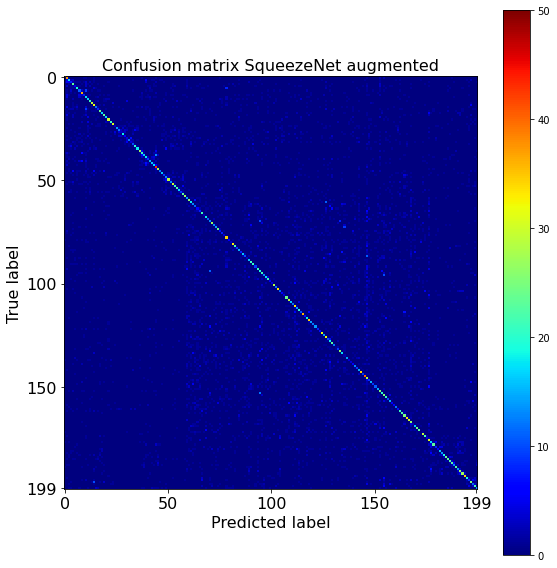

In [49]:
plot_confusion_matrix_TIN(cm,title='Confusion matrix SqueezeNet augmented',
                          saveas='squeezeNet_TIN_aug_confmat',)

In [50]:
IFrame("./models/squeezeNetTIN_aug.pdf", width=900, height=400)

In [51]:
analyze_predictions_TIN(cm)


 least correct predictions


,label,correct amount
0,water jug,0
1,plunger,1
2,pop bottle,2
3,barrel,3
4,umbrella,3
5,Labrador retriever,3
6,Chihuahua,3
7,bucket,3
8,chain,3
9,dumbbell,4



 most correct predictions, labels, times correct predicted:


,label,correct amount
0,monarch,43
1,school bus,40
2,European fire salamander,37
3,black widow,36
4,lifeboat,36
5,brass,34
6,espresso,34
7,rugby ball,34
8,maypole,34
9,triumphal arch,33



 most confused labels:


,actual label,predicted label,times confused
0,bee,monarch,13
1,sports car,convertible,12
2,CD player,scoreboard,11
3,altar,organ,11
4,convertible,beach wagon,11
5,coral reef,brain coral,10
6,dam,steel arch bridge,10
7,beach wagon,convertible,10
8,scorpion,centipede,9
9,slug,centipede,9



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,jinrikisha,beach wagon,pay-phone,organ,comic book,centipede,monarch,steel arch bridge,convertible,scoreboard


\begin{tabular}{lrlrllr}
\toprule
             label &  correct amount &                    label &  correct amount & actual label &   predicted label &  times confused \\
\midrule
         water jug &               0 &                  monarch &              43 &          bee &           monarch &              13 \\
           plunger &               1 &               school bus &              40 &   sports car &       convertible &              12 \\
        pop bottle &               2 & European fire salamander &              37 &    CD player &        scoreboard &              11 \\
            barrel &               3 &              black widow &              36 &        altar &             organ &              11 \\
          umbrella &               3 &                 lifeboat &              36 &  convertible &       beach wagon &              11 \\
Labrador retriever &               3 &                    brass &              34 &   coral reef &       brain coral &           

## Res50Net augmented 

In [53]:
# to load the wrapped Res50Net architecture we need to recreate it here
def res50Net_transfer(input_shape, n_classes, frozen_layers=168, final_layers=[]):
    # load resnet with given input shape
    input_t = tf.keras.Input(shape=input_shape)
    res_model = tf.keras.applications.ResNet50(include_top=False,
                                              weights="imagenet",
                                              input_tensor=input_t)
    # freeze top layers of resnet
    for layer in res_model.layers[:frozen_layers]:
        layer.trainable =False

    # wrap resnet by sequencial network
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Lambda(lambda image: tf.image.resize(image, input_shape[:2])))
    model.add(res_model)
    model.add(tf.keras.layers.Flatten())

    for n_layer in final_layers: # add dense layers if we need more accuracy
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(n_layer, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

    loss = tf.keras.losses.CategoricalCrossentropy()
    adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model

In [54]:
# TinyIageNet has 200 classes
N_CLASSES = 200
# our input dimensions
INSHAPE = 64, 64, 3
PICTURE_SHAPE = INSHAPE[0], INSHAPE[1]

In [55]:
test_gen = load_TIN(1000)

The zip file already exists.
The extracted data already exists
Found 10000 validated image filenames belonging to 200 classes.


In [56]:
tf.keras.backend.clear_session()
model = res50Net_transfer(INSHAPE, N_CLASSES, frozen_layers=168, 
                          final_layers=[256, 256, 256])
model.build((1000,64,64,3))
model.load_weights(os.path.join('models','res50Net_TIN_aug.h5'))

In [57]:
# Evaluate the model
test_res = model.evaluate(test_gen)
# Print the results as a dictionary {<metric name>: <value>}
test_res_dict = dict(zip(model.metrics_names, test_res))
print(test_res_dict)

10/10 [==============================] - 120s 12s/step - loss: 2.6715 - accuracy: 0.3770
{'loss': 2.6715474128723145, 'accuracy': 0.37700000405311584}


In [58]:
p_test = model.predict(test_gen).argmax(axis=1)
test_gen = load_TIN()
cm = confusion_matrix(np.argmax(test_gen[0][1],axis=1), p_test)

The zip file already exists.
The extracted data already exists
Found 10000 validated image filenames belonging to 200 classes.


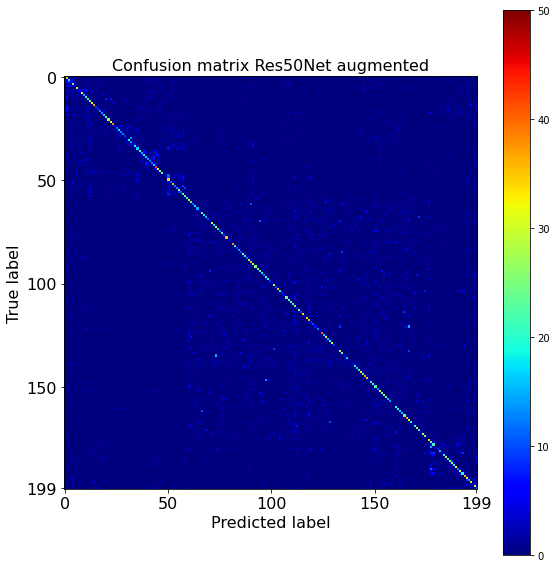

In [59]:
plot_confusion_matrix_TIN(cm,title='Confusion matrix Res50Net augmented',
                          saveas='res50Net_TIN_aug_confmat',)

In [60]:
IFrame("./models/res50Net_TIN_aug.pdf", width=900, height=400)

In [61]:
analyze_predictions_TIN(cm)


 least correct predictions


,label,correct amount
0,plunger,0
1,hog,0
2,syringe,1
3,wooden spoon,1
4,ox,2
5,bucket,2
6,projectile,2
7,ice cream,2
8,tabby,3
9,beach wagon,3



 most correct predictions, labels, times correct predicted:


,label,correct amount
0,monarch,42
1,obelisk,40
2,bullet train,38
3,dugong,38
4,school bus,37
5,brain coral,37
6,espresso,36
7,triumphal arch,36
8,maypole,36
9,Christmas stocking,36



 most confused labels:


,actual label,predicted label,times confused
0,pop bottle,beer bottle,15
1,ice cream,plate,15
2,moving van,trolleybus,15
3,tabby,Egyptian cat,14
4,sewing machine,desk,13
5,meat loaf,plate,11
6,beach wagon,convertible,11
7,hog,bison,11
8,orange,lemon,10
9,turnstile,pay-phone,10



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,Christmas stocking,maypole,academic gown,beer bottle,jinrikisha,European fire salamander,desk,trolleybus,bison,plate


\begin{tabular}{lrlrllr}
\toprule
       label &  correct amount &              label &  correct amount &   actual label & predicted label &  times confused \\
\midrule
     plunger &               0 &            monarch &              42 &     pop bottle &     beer bottle &              15 \\
         hog &               0 &            obelisk &              40 &      ice cream &           plate &              15 \\
     syringe &               1 &       bullet train &              38 &     moving van &      trolleybus &              15 \\
wooden spoon &               1 &             dugong &              38 &          tabby &    Egyptian cat &              14 \\
          ox &               2 &         school bus &              37 & sewing machine &            desk &              13 \\
      bucket &               2 &        brain coral &              37 &      meat loaf &           plate &              11 \\
  projectile &               2 &           espresso &              36 &    

## Res50Net not augmented 

In [62]:
# TinyIageNet has 200 classes
N_CLASSES = 200
# our input dimensions
INSHAPE = 64, 64, 3
PICTURE_SHAPE = INSHAPE[0], INSHAPE[1]

In [63]:
test_gen = load_TIN(1000)

The zip file already exists.
The extracted data already exists
Found 10000 validated image filenames belonging to 200 classes.


In [64]:
tf.keras.backend.clear_session()
model = res50Net_transfer(INSHAPE, N_CLASSES, frozen_layers=168, 
                          final_layers=[256, 256, 256])
model.build((1000,64,64,3))
model.load_weights(os.path.join('models','res50NetTIN_noaug.h5'))

In [65]:
# Evaluate the model
test_res = model.evaluate(test_gen)
# Print the results as a dictionary {<metric name>: <value>}
test_res_dict = dict(zip(model.metrics_names, test_res))
print(test_res_dict)

10/10 [==============================] - 120s 12s/step - loss: 2.9810 - accuracy: 0.3457
{'loss': 2.981005907058716, 'accuracy': 0.3456999957561493}


In [66]:
p_test = model.predict(test_gen).argmax(axis=1)
test_gen = load_TIN()
cm = confusion_matrix(np.argmax(test_gen[0][1],axis=1), p_test)

The zip file already exists.
The extracted data already exists
Found 10000 validated image filenames belonging to 200 classes.


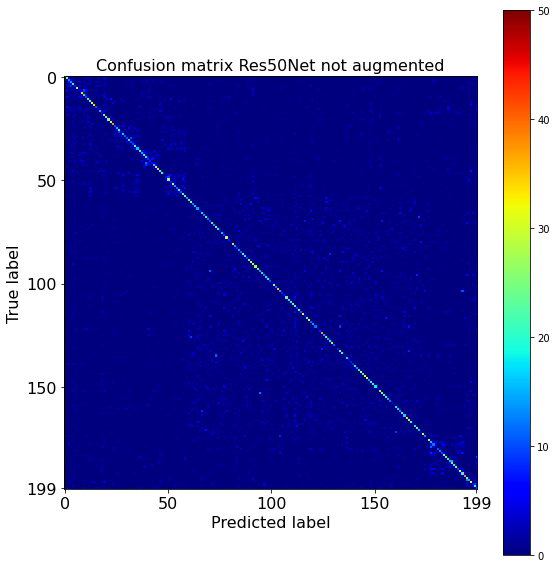

In [67]:
plot_confusion_matrix_TIN(cm,title='Confusion matrix Res50Net not augmented',
                          saveas='res50NetTIN_noaug_confmat',)

In [68]:
IFrame("./models/res50NetTIN_noaug.pdf", width=900, height=400)